In [35]:
import math, random
import pandas as pd
import sklearn
import pickle as pkl
import re

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import gensim

import matplotlib.pyplot as plt
%matplotlib inline

## Problem-70

In [2]:
columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
label_map = {'b':0, 't':1, 'e': 2, 'm':3 }
categs = ['busi.', 'science', 'enter.', 'health']

In [3]:
w2vmodel = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [4]:
df = pd.read_csv('NewsAggregatorDataset/newsCorpora.csv', sep='\t', quoting=3, names=columns)
train_split = df.sample(frac=0.8, random_state=43)
test_valid_split = df.drop(train_split.index)
valid_split = test_valid_split.sample(frac=0.5, random_state=43)
test_split = test_valid_split.drop(valid_split.index)
print(len(train_split), len(valid_split), len(test_split))

338350 42294 42293


In [5]:
def title_to_embed(x):
    title = re.sub('[^A-Za-z0-9]', ' ', x.lower())
#     title=x
    title_array = np.zeros(300)
    length = 0
    split_title = title.split()
    for token in split_title:
        if token in w2vmodel:
            title_array+=w2vmodel[token.strip()]
    return (title_array/max(length, 1))

In [128]:
train_data = np.array(list(train_split['TITLE'].apply(title_to_embed)), dtype='float32')
# train_data_filtered = list(filter(lambda x: np.sum(x)>0, list(train_split['TITLE'].apply(title_to_embed))))
# train_data = np.array(train_data_filtered, dtype='float32')
train_label = np.array(list(train_split['CATEGORY'].apply(lambda x: label_map[x])))
valid_data = np.array(list(valid_split['TITLE'].apply(title_to_embed)), dtype='float32')
valid_label = np.array(list(valid_split['CATEGORY'].apply(lambda x: label_map[x])))
test_data = np.array(list(test_split['TITLE'].apply(title_to_embed)), dtype='float32')
test_label = np.array(list(test_split['CATEGORY'].apply(lambda x: label_map[x])))
all_splits = {'train_data': train_data, 'train_label':train_label, 'valid_data': valid_data, 'valid_label':valid_label,\
             'test_data': test_data, 'test_label':test_label}

In [131]:
with open('chapter_8_splits.pkl', 'wb') as outfile:
    pkl.dump(all_splits, outfile)

## Problem-71

In [36]:
all_data = None
with open('chapter_8_splits.pkl', 'rb') as infile:
    all_data = pkl.load(infile)
# train_data = data['train_data']
# train_label = data['train_label']
# valid_data = data['valid_data']
# valid_label = data['valid_label']
# test_data = data['test_data']
# test_label = data['test_label']
# print(train_data.shape, train_label.shape)

In [37]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)
            
    def forward(self, x):
        x = self.linear1(x)
#         x = F.softmax(x, dim=-1)
        return x

In [38]:
class MyDataSet(Dataset):
    def __init__(self, data, label, transform=None):
        self.transform = transform

        self.data = data
        self.label = label

        self.datanum = label.shape[0]

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

## Problem-71 and Problem-72

In [39]:
train_set = MyDataSet(all_data['train_data'], all_data['train_label'], transform=torch.as_tensor)
small_loader = DataLoader(train_set, batch_size=4)
embeds, labels = next(iter(small_loader))
model_ = LinearModel(300, 4)
preds = F.softmax(model_(embeds), dim=-1)
print('softmax x1', preds[:1,:])
print('softmax x1-x4', preds)
loss4 = F.cross_entropy(preds, labels)
# print(labels[0],labels[0], labels[0].dtype)
loss1 = F.cross_entropy(preds[:1, :], labels[0].unsqueeze(0))
print('loss x1', loss1)
print('loss x1-x4', loss4)

softmax x1 tensor([[0.3627, 0.2798, 0.1932, 0.1642]], grad_fn=<SliceBackward>)
softmax x1-x4 tensor([[0.3627, 0.2798, 0.1932, 0.1642],
        [0.3154, 0.2856, 0.1401, 0.2590],
        [0.3874, 0.1441, 0.1050, 0.3634],
        [0.4407, 0.1940, 0.1798, 0.1856]], grad_fn=<SoftmaxBackward>)
loss x1 tensor(1.3595, grad_fn=<NllLossBackward>)
loss x1-x4 tensor(1.4614, grad_fn=<NllLossBackward>)


## Problem-73  (Training with batch size=1)

In [40]:
# @torch.no_grad()
def get_accuracy(model, split, USE_CUDA):
    data = all_data[split + '_data']
    labels = all_data[split + '_label']
    dataset = MyDataSet(data, labels, transform=torch.as_tensor)
    dataloader = DataLoader(dataset, batch_size=len(data), num_workers=0)
    features, labels = next(iter(dataloader))
    features = features.to(cuda) if USE_CUDA else features
    labels = labels.to(cuda) if USE_CUDA else labels
    num_correct = get_correct_responses(model, features, labels)
    return num_correct/len(labels)
    

In [41]:
@torch.no_grad()
def get_correct_responses(model, features, labels):
    preds = model(features)
    return_val = F.softmax(preds, dim=-1).argmax(dim=1).eq(labels).sum().item()
    return return_val

In [42]:
@torch.no_grad()
def get_eval_loss(model, split, USE_CUDA, batch_size):
    data = all_data[split + '_data']
    labels = all_data[split + '_label']
    dataset = MyDataSet(data, labels, transform=torch.as_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0)
    num_batches = 0
    all_loss = 0
    for idx, batch in enumerate(dataloader):
        features, labels = batch
        features = features.to(cuda) if USE_CUDA else features
        labels = labels.to(cuda) if USE_CUDA else labels
        out = model(features)
        loss = F.cross_entropy(out, labels)
        all_loss += loss
        num_batches = idx
    return all_loss/(num_batches+1)

In [208]:
cuda = torch.device('cuda')
# model = LinearModel(300, 4)
def train_model(model, USE_CUDA, num_epoch, train_set, bsize, l_rate):
    train_loader = DataLoader(train_set, batch_size=bsize, num_workers=0)
    model = model.to(cuda) if USE_CUDA else model
    optimizer = optim.SGD(model.parameters(), lr=l_rate)
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    for epoch in range(num_epoch):
        epoch_loss = 0
        num_batches = 0
        for idx, batch in enumerate(train_loader):
    #         print(idx)
            features, labels = batch 
            features = features.to(cuda) if USE_CUDA else features
            labels = labels.to(cuda) if USE_CUDA else labels
            out = model(features)
            loss = F.cross_entropy(out, labels)
            epoch_loss += loss
            
            #backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            num_batches = idx
        train_loss = epoch_loss/(num_batches+1)
        valid_loss = get_eval_loss(model, 'valid', USE_CUDA, batch_size)
        train_acc = get_accuracy(model, 'train', USE_CUDA)
        valid_acc = get_accuracy(model, 'valid', USE_CUDA)
        
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        print(f'epoch: {epoch+1}, training loss = {train_loss}, valid loss = {valid_loss}')
        print(f'train accuarcy: {train_acc},  valid accuracy: {valid_acc}')
#     plt.show()
    return model

        
# model = train_model(model, False, 1, train_set, 1, 0.01)

In [204]:
next(model.parameters()).is_cuda

False

## Problem-74
### Calculating the accuracy for all splits

In [205]:
splits = ['train', 'valid', 'test']
for i in splits:
    print(f'{i}_accuracy: {get_accuracy(model, i, False)}')

train_accuracy: 0.855634697798138
valid_accuracy: 0.8581831938336407
test_accuracy: 0.8532854136618353


## Problem 75
### plotting the loss and accuracy

In [61]:
def train_model(model, USE_CUDA, num_epoch, train_set, bsize, l_rate):
    train_loader = DataLoader(train_set, batch_size=bsize, num_workers=0)
    model = model.to(cuda) if USE_CUDA else model
    optimizer = optim.SGD(model.parameters(), lr=l_rate)
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    for epoch in range(num_epoch):
        epoch_loss = 0
        num_batches = 0
        for idx, batch in enumerate(train_loader):
            features, labels = batch 
            features = features.to(cuda) if USE_CUDA else features
            labels = labels.to(cuda) if USE_CUDA else labels
            out = model(features)
            loss = F.cross_entropy(out, labels)
            epoch_loss += loss
            
            #backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            num_batches = idx
        train_loss = epoch_loss/(num_batches+1)
        valid_loss = get_eval_loss(model, 'valid', USE_CUDA, bsize)
        train_acc = get_accuracy(model, 'train', USE_CUDA)
        valid_acc = get_accuracy(model, 'valid', USE_CUDA)
        
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        print(f'epoch: {epoch+1}, training loss = {train_loss}, valid loss = {valid_loss}')
        print(f'train accuarcy: {train_acc},  valid accuracy: {valid_acc}')
    
    #plotting loss and accuarcy
    plt.figure(figsize=(10, 4))
    plt.title('Avg batch loss per epoch')
    plt.plot(range(len(train_losses)), train_losses, label='training loss')
    plt.plot(range(len(valid_losses)), valid_losses, label='valid loss')
    plt.legend()
    
    plt.figure(figsize=(10, 4))
    plt.title('Accuracy after each epoch')
    plt.plot(range(len(train_accs)), train_accs, label='training acc.')
    plt.plot(range(len(valid_accs)), valid_accs, label='valid acc.')
    plt.legend()
    return model





In [ ]:
model = LinearModel(300, 4)
model = train_model(model, False, 3, train_set, 1, 0.001)

## Problem 76
### saving checkpoints of a model

In [62]:
def train_model_save_checkpoint(model, USE_CUDA, num_epoch, train_set, bsize, l_rate):
    train_loader = DataLoader(train_set, batch_size=bsize, num_workers=0)
    model = model.to(cuda) if USE_CUDA else model
    optimizer = optim.SGD(model.parameters(), lr=l_rate)
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    for epoch in range(num_epoch):
        epoch_loss = 0
        num_batches = 0
        for idx, batch in enumerate(train_loader):
            features, labels = batch 
            features = features.to(cuda) if USE_CUDA else features
            labels = labels.to(cuda) if USE_CUDA else labels
            out = model(features)
            loss = F.cross_entropy(out, labels)
            epoch_loss += loss
            
            #backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            num_batches = idx
        train_loss = epoch_loss/(num_batches+1)
        valid_loss = get_eval_loss(model, 'valid', USE_CUDA, bsize)
        train_acc = get_accuracy(model, 'train', USE_CUDA)
        valid_acc = get_accuracy(model, 'valid', USE_CUDA)
        
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        print(f'epoch: {epoch+1}, training loss = {train_loss}, valid loss = {valid_loss}')
        print(f'train accuarcy: {train_acc},  valid accuracy: {valid_acc}')
        # saving checkpoints during the training
        torch.save({'epoch': epoch + 1, 'model_state_dict': model.state_dict(), \
                    'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
    plt.figure(figsize=(10, 4))
    plt.title('Avg batch loss per epoch')
    plt.plot(range(len(train_losses)), train_losses, label='training loss')
    plt.plot(range(len(valid_losses)), valid_losses, label='valid loss')
    plt.legend()
    
    plt.figure(figsize=(10, 4))
    plt.title('Accuracy after each epoch')
    plt.plot(range(len(train_accs)), train_accs, label='training acc.')
    plt.plot(range(len(valid_accs)), valid_accs, label='valid acc.')
    plt.legend()
    return model

epoch: 1, training loss = 0.5173352956771851, valid loss = 0.44438406825065613
train accuarcy: 0.8418176444510123,  valid accuracy: 0.8428855156759824
epoch: 2, training loss = 0.43340742588043213, valid loss = 0.42277514934539795
train accuarcy: 0.8483493423969263,  valid accuracy: 0.8500732964486688
epoch: 3, training loss = 0.4201960861682892, valid loss = 0.4141823351383209
train accuarcy: 0.8511245751440816,  valid accuracy: 0.8531943065210196


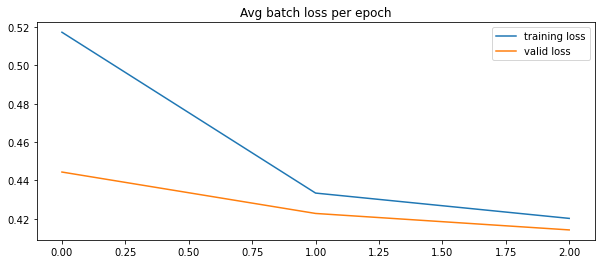

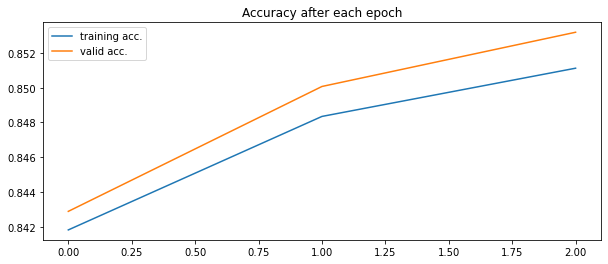

In [218]:
model = LinearModel(300, 4)
model = train_model_save_checkpoint(model, False, 3, train_set, 1, 0.0001)

## Problem 77
### training with different batch sizes

In [48]:
cuda = torch.device('cuda')
def train_model_single_epoch(model, USE_CUDA, train_set, bsize, l_rate):
    import time
    train_loader = DataLoader(train_set, batch_size=bsize, num_workers=1)
    model = model.to(cuda) if USE_CUDA else model
    optimizer = optim.SGD(model.parameters(), lr=l_rate)
    epoch_loss = 0
    num_batches = 0
    start_time = time.time()
    for idx, batch in enumerate(train_loader):
        if idx and idx%100000==0:
            print(idx)
        features, labels = batch 
        features = features.to(cuda) if USE_CUDA else features
        labels = labels.to(cuda) if USE_CUDA else labels
        out = model(features)
        loss = F.cross_entropy(out, labels)
        epoch_loss += loss

        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_batches = idx
    train_loss = epoch_loss/(num_batches+1)
    valid_loss = get_eval_loss(model, 'valid', USE_CUDA, bsize)
    train_acc = get_accuracy(model, 'train', USE_CUDA)
    valid_acc = get_accuracy(model, 'valid', USE_CUDA)
    print(f'training loss = {train_loss}, valid loss = {valid_loss}')
    print(f'train accuarcy: {train_acc},  valid accuracy: {valid_acc}')
    print(f'time for training 1 epoch; {time.time() - start_time}')
    print()
    return train_loss, valid_loss, train_acc, valid_acc

In [46]:
#train with different batch sizes
for i in range(6):
    print(f'batch_size: {2**i}')
    model = LinearModel(300, 4)
    train_loss, valid_loss, train_acc, valid_acc = train_model_single_epoch(model, False, train_set, 2**i, 0.001)

batch_size: 1
100000
200000
300000
training loss = 0.42851144075393677, valid loss = 0.404374361038208
train accuarcy: 0.8538052312693956,  valid accuracy: 0.8565281127346669
time for training 1 epoch; 423.7133972644806

batch_size: 2
100000
training loss = 0.4416731595993042, valid loss = 0.40841177105903625
train accuarcy: 0.8527176001182207,  valid accuracy: 0.8551094717926893
time for training 1 epoch; 207.04342699050903

batch_size: 4
training loss = 0.46582406759262085, valid loss = 0.41833382844924927
train accuarcy: 0.8497059258164622,  valid accuracy: 0.8519884617203386
time for training 1 epoch; 111.71878838539124

batch_size: 8
training loss = 0.5013200640678406, valid loss = 0.4363898038864136
train accuarcy: 0.8441022609723658,  valid accuracy: 0.8454390693715421
time for training 1 epoch; 60.26902985572815

batch_size: 16
training loss = 0.5543324947357178, valid loss = 0.46507400274276733
train accuarcy: 0.8362051130486183,  valid accuracy: 0.8374946800964675
time for tr

## Problem 78
### training with a gpu

In [49]:
#train with different batch sizes
for i in range(6):
    print(f'batch_size: {2**i}')
    model = LinearModel(300, 4)
    #set the USE_CUDA parameter to True to train with GPU
    train_loss, valid_loss, train_acc, valid_acc = train_model_single_epoch(model, True, train_set, 2**i, 0.001)

batch_size: 1
100000
200000
300000
training loss = 0.42889371514320374, valid loss = 0.40440160036087036
train accuarcy: 0.8539323186049949,  valid accuracy: 0.8567409088759635
time for training 1 epoch; 461.7187411785126

batch_size: 2
100000
training loss = 0.4423905909061432, valid loss = 0.40812355279922485
train accuarcy: 0.8527471553125462,  valid accuracy: 0.8552276918711874
time for training 1 epoch; 231.90143990516663

batch_size: 4
training loss = 0.46661293506622314, valid loss = 0.4186004400253296
train accuarcy: 0.850022166395744,  valid accuracy: 0.8515155814063461
time for training 1 epoch; 120.69118928909302

batch_size: 8
training loss = 0.5054785013198853, valid loss = 0.4366382658481598
train accuarcy: 0.8434579577360721,  valid accuracy: 0.8446115288220551
time for training 1 epoch; 62.307459592819214

batch_size: 16
training loss = 0.553540050983429, valid loss = 0.4646625220775604
train accuarcy: 0.8366070636914438,  valid accuracy: 0.8369272237196765
time for tra

## Problem 79
### Training multi-layer network

In [63]:
class MultiLayerModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLayerModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 120)
        self.linear2 = nn.Linear(120, output_size)
            
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
#         x = F.softmax(x, dim=-1)
        return x

In [ ]:
# model = MultiLayerModel(300, 4)
train_model(model, True, 5, train_set, 16, 0.0001)

epoch: 1, training loss = 0.14284013211727142, valid loss = 0.22224050760269165
train accuarcy: 0.9524782030441851,  valid accuracy: 0.9262306710171656
epoch: 2, training loss = 0.14244724810123444, valid loss = 0.22218556702136993
train accuarcy: 0.952555046549431,  valid accuracy: 0.9264198231427626
epoch: 3, training loss = 0.1422707587480545, valid loss = 0.2221551239490509
train accuarcy: 0.9526348455741096,  valid accuracy: 0.9264198231427626
epoch: 4, training loss = 0.14215311408042908, valid loss = 0.22213318943977356
train accuarcy: 0.9527589773902764,  valid accuracy: 0.9265616872369603
